##### Read in and Preperation

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# read in the data 
df = pd.read_csv('transactions_n100000.csv',parse_dates=['order_timestamp'])

In [3]:
# inspect the first few rows 
df.head()

,ticket_id,order_timestamp,location,item_name,item_count,lat,long
0,0x7901ee,2019-01-16 18:33:00,7,shake,2,41.794132,-88.010140
1,0x7901ee,2019-01-16 18:33:00,7,burger,2,41.794132,-88.010140
2,0x7901ee,2019-01-16 18:33:00,7,fries,2,41.794132,-88.010140
3,0x12b47f,2019-09-04 12:36:00,3,salad,1,41.884490,-87.627059
4,0x12b47f,2019-09-04 12:36:00,3,fries,1,41.884490,-87.627059


In [4]:
# check to see if we need any cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260645 entries, 0 to 260644
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ticket_id        260645 non-null  object        
 1   order_timestamp  260645 non-null  datetime64[ns]
 2   location         260645 non-null  int64         
 3   item_name        260645 non-null  object        
 4   item_count       260645 non-null  int64         
 5   lat              260645 non-null  float64       
 6   long             260645 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 13.9+ MB


Location should be categorical, and is now represented in integer. We need to convert that.

In [5]:
# convert location into categorical
df['location'] = df['location'].astype('str')

##### Reshape and Feature Engineering

Since we want to do customer segmentation, we should have each customer (represented by transaction), for each row. To achieve this, we need to first reshape our data.

In [6]:
# Reshape our data:

df1 = df.pivot(index = 'ticket_id',columns ='item_name',values='item_count').fillna(0) 
merged = pd.merge(right = df1, left = df.drop_duplicates(subset=['ticket_id']),right_index=True,left_on='ticket_id',how = 'inner')
merged.reset_index(drop=True,inplace=True) 
merged.drop(['item_name', 'item_count'],axis=1,inplace=True)

In [7]:
# inspect the merged data
merged.head()

,ticket_id,order_timestamp,location,lat,long,burger,fries,salad,shake
0,0x7901ee,2019-01-16 18:33:00,7,41.794132,-88.010140,2.0,2.0,0.0,2.0
1,0x12b47f,2019-09-04 12:36:00,3,41.884490,-87.627059,0.0,1.0,1.0,0.0
2,0x6d6979,2019-03-18 00:27:00,6,41.784576,-87.607565,2.0,2.0,0.0,0.0
3,0x78dd1e,2019-09-22 00:10:00,2,42.049306,-87.677606,2.0,2.0,0.0,2.0
4,0x4df8ab,2019-01-17 11:35:00,8,41.894202,-87.620965,0.0,3.0,3.0,0.0


In [8]:
# save id for further use
id_col = merged['ticket_id']

In [9]:
# Hour and day of week may be influential
merged['Hour'] = merged['order_timestamp'].dt.hour
merged['Day of Week'] = merged['order_timestamp'].dt.dayofweek

In [10]:
# clean up the dataframe and get rid of some columns 
merged.drop(['ticket_id','order_timestamp','lat','long'],axis=1,inplace=True)

In [11]:
# inspect again
merged.head()

,location,burger,fries,salad,shake,Hour,Day of Week
0,7,2.0,2.0,0.0,2.0,18,2
1,3,0.0,1.0,1.0,0.0,12,2
2,6,2.0,2.0,0.0,0.0,0,0
3,2,2.0,2.0,0.0,2.0,0,6
4,8,0.0,3.0,3.0,0.0,11,3


In [12]:
# change the type of hour and day of week into string for further processing 
merged['Hour'] = merged['Hour'].astype(str)
merged['Day of Week'] = merged['Day of Week'].astype(str)

In [13]:
# create dining window labels - timeframe from visualization 
def get_dining_time(hour):
    hour = int(hour)
    if hour >= 1 and hour <= 15:
        return('Lunch')
    elif hour >= 16 and hour <= 21:
        return('Dinner')
    else: return("Late Night")

In [14]:
# create weekend weekday labels
def weekday(day):
    day = int(day)
    if day in [5,6]:
        return("Weekend")
    else: return("Weekday")

In [15]:
# create our new columns 
merged['Meal'] = merged['Hour'].apply(get_dining_time)
merged['Day of Week'] =merged['Day of Week'].apply(weekday)

In [16]:
# get rid of the hour column, we only need the meal col
merged.drop('Hour',axis=1,inplace=True)

In [17]:
# check out the meal column
merged['Meal'].value_counts(dropna=False)

Lunch         37481
Dinner        34032
Late Night    28487
Name: Meal, dtype: int64

In [18]:
# transform categorical variables into dummy columns 
df_new = pd.get_dummies(merged)

In [19]:
# split data 
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_new, test_size=0.33, random_state=42)

In [20]:
# scale data after splitting (fit using training set)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X1 = scaler.fit_transform(train)
X2 = scaler.transform(test)

X = scaler.transform(df_new)

##### Training the model

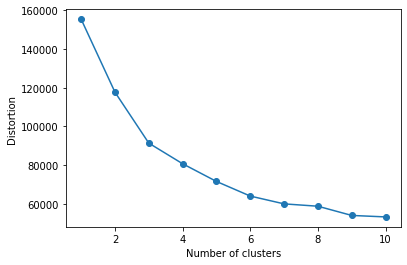

In [21]:

from sklearn.cluster import KMeans
# use the elbow method

# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X1)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [22]:
# use our optimal k
km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y1 = km.fit_predict(X1)
y2 = km.predict(X2)
y_km = km.predict(X)

In [23]:
# assign the split dataframes back to dataframe
train = pd.DataFrame(train,columns=df_new.columns)
test = pd.DataFrame(test,columns=df_new.columns)

In [24]:
# assign results back to the dataframes
train['Cluster'] = y1
test['Cluster'] = y2

##### Evaluate Results

In [25]:
# check out the train clusters

train.groupby(by='Cluster').mean()

,burger,fries,salad,shake,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9,Day of Week_Weekday,Day of Week_Weekend,Meal_Dinner,Meal_Late Night,Meal_Lunch
Cluster,,,,,,,,,,,,,,,,,,
0,0.551181,2.194623,1.643442,0.154021,0.172314,0.091704,0.174859,0.041995,0.174302,0.091426,0.039450,0.173666,0.040285,0.714587,0.285413,0.000000,0.0,1.000000
1,1.754961,1.818603,0.063642,0.320051,0.032005,0.394483,0.033321,0.029478,0.023267,0.393536,0.030584,0.032584,0.030742,0.712323,0.287677,0.000000,1.0,0.000000
2,3.384740,3.612941,0.228201,3.202739,0.034213,0.029838,0.035525,0.260927,0.036400,0.031631,0.263114,0.043269,0.265083,0.714617,0.285383,0.999387,0.0,0.000613


In [26]:
# check out the test clusters

test.groupby(by='Cluster').mean()

,burger,fries,salad,shake,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9,Day of Week_Weekday,Day of Week_Weekend,Meal_Dinner,Meal_Late Night,Meal_Lunch
Cluster,,,,,,,,,,,,,,,,,,
0,0.550349,2.194169,1.643820,0.159899,0.175573,0.087867,0.174517,0.037681,0.17476,0.090385,0.043446,0.175897,0.039873,0.718126,0.281874,0.000000,0.0,1.000000
1,1.745838,1.807587,0.061749,0.322550,0.031401,0.399895,0.034563,0.028030,0.02255,0.390622,0.028872,0.033193,0.030875,0.706849,0.293151,0.000000,1.0,0.000000
2,3.382905,3.611379,0.228474,3.194980,0.034119,0.031440,0.035638,0.265452,0.03403,0.032333,0.263934,0.044748,0.258307,0.716952,0.283048,0.999375,0.0,0.000625


In [27]:
# check cluster proportions - train 
for i in [0,1,2]:
    print("Cluster {} is {}%".format(i,train['Cluster'].value_counts()[i]/670))

Cluster 0 is 37.53134328358209%
Cluster 1 is 28.35373134328358%
Cluster 2 is 34.11492537313433%


In [28]:
# check cluster proportions - test
for i in [0,1,2]:
    print("Cluster {} is {}%".format(i,test['Cluster'].value_counts()[i]/330))

Cluster 0 is 37.31515151515151%
Cluster 1 is 28.757575757575758%
Cluster 2 is 33.92727272727273%


It seems like the clusters are quite stable between train and test sets. 

In [29]:
df_new['Cluster'] = y_km # predict on whole dataset

# check out the clusters - whole dataset 

df_new.groupby(by='Cluster').mean()

,burger,fries,salad,shake,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9,Day of Week_Weekday,Day of Week_Weekend,Meal_Dinner,Meal_Late Night,Meal_Lunch
Cluster,,,,,,,,,,,,,,,,,,
0,0.550908,2.194474,1.643566,0.155953,0.173385,0.090443,0.174746,0.040577,0.174453,0.091084,0.040763,0.174399,0.040149,0.715750,0.284250,0.000000,0.0,1.000000
1,1.751922,1.814933,0.063011,0.320883,0.031804,0.396286,0.033735,0.028996,0.023028,0.392565,0.030014,0.032787,0.030786,0.710500,0.289500,0.000000,1.0,0.000000
2,3.384136,3.612428,0.228291,3.200188,0.034182,0.030364,0.035562,0.262414,0.035621,0.031862,0.263384,0.043755,0.262855,0.715385,0.284615,0.999383,0.0,0.000617


In [30]:
# assign ticket id back to the dataset for further visualization
df_new = pd.concat([df_new,id_col],axis=1)

In [31]:
# save the result on the whole dataset to file 
df_new.to_csv('Result.csv')

In [32]:
df_new.head()

,burger,fries,salad,shake,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9,Day of Week_Weekday,Day of Week_Weekend,Meal_Dinner,Meal_Late Night,Meal_Lunch,Cluster,ticket_id
0,2.0,2.0,0.0,2.0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,2,0x7901ee
1,0.0,1.0,1.0,0.0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0x12b47f
2,2.0,2.0,0.0,0.0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0x6d6979
3,2.0,2.0,0.0,2.0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0x78dd1e
4,0.0,3.0,3.0,0.0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0x4df8ab
